### Summary
* US census data from 1994-1995
* objective 2: population segmentation
* objective 1: predict the yearly income (the data is labeled for this task, see below)

# EDA
Data is contained in file `census-income.data`, with column names contained in `census-income.columns`.
We start by loading the data.

In [1]:
# load column names
# load column names
col_names = []
with open('census-income.columns', 'r') as f:
    for line in f.readlines():
        col_names.append(line[:-1])

In [2]:
# load data
import pandas as pd
df = pd.read_csv('census-income.data', names=col_names)

In [3]:
print(f"There are {len(df)} samples, and {len(df.columns)} features.")

There are 199523 samples, and 42 features.


In [4]:
# quickly check for nan values
df.isna().any() 

age                                           False
class of worker                               False
detailed industry recode                      False
detailed occupation recode                    False
education                                     False
wage per hour                                 False
enroll in edu inst last wk                    False
marital stat                                  False
major industry code                           False
major occupation code                         False
race                                          False
hispanic origin                                True
sex                                           False
member of a labor union                       False
reason for unemployment                       False
full or part time employment stat             False
capital gains                                 False
capital losses                                False
dividends from stocks                         False
tax filer st

In [5]:
# hispanic origin is the only feature with nan values
# let's have a closer look
df['hispanic origin'].isna().sum()

874

In [6]:
# not many nan values
df['hispanic origin'].value_counts()

All other                    171907
Mexican-American               8079
Mexican (Mexicano)             7234
Central or South American      3895
Puerto Rican                   3313
Other Spanish                  2485
Cuban                          1126
Do not know                     306
Chicano                         304
Name: hispanic origin, dtype: int64

In [7]:
# replace nans in hispanic origin
def fill_nan_hisp(data):
    """
    assumes data is a pandas dataframe
    modifies data in place
    """
    assert 'hispanic origin' in data.columns, "Hispanic column missing"
    df['hispanic origin'].fillna(value='All other', inplace=True)
    return None

fill_nan_hisp(df)

In [8]:
# quick look at features again
df.columns

Index(['age', 'class of worker', 'detailed industry recode',
       'detailed occupation recode', 'education', 'wage per hour',
       'enroll in edu inst last wk', 'marital stat', 'major industry code',
       'major occupation code', 'race', 'hispanic origin', 'sex',
       'member of a labor union', 'reason for unemployment',
       'full or part time employment stat', 'capital gains', 'capital losses',
       'dividends from stocks', 'tax filer stat',
       'region of previous residence', 'state of previous residence',
       'detailed household and family stat',
       'detailed household summary in household', 'instance weight',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'live in this house 1 year ago',
       'migration prev res in sunbelt', 'num persons worked for employer',
       'family members under 18', 'country of birth father',
       'country of birth mother', 'country of birth self', 'citizenship',
 

## Note:
Two columns play a different role: instance weight, and label:
* instance weight is a weight assigned from stratified sampling
* label is the binary output to be predicted

In [9]:
# quick look at data types
df.dtypes

age                                             int64
class of worker                                object
detailed industry recode                        int64
detailed occupation recode                      int64
education                                      object
wage per hour                                   int64
enroll in edu inst last wk                     object
marital stat                                   object
major industry code                            object
major occupation code                          object
race                                           object
hispanic origin                                object
sex                                            object
member of a labor union                        object
reason for unemployment                        object
full or part time employment stat              object
capital gains                                   int64
capital losses                                  int64
dividends from stocks       

In [10]:
# collect continuous and discrete variables
numerical_types = ['int64', 'float64']
var_cont = set()
var_disc = set()
for col in col_names:
    if df.dtypes[col] in numerical_types:
        var_cont.add(col)
    else:
        var_disc.add(col)

In [11]:
# we remove the two special variables
var_cont.remove('instance weight')
var_disc.remove('label')

## Sanity check
Let's plot a histogram of age, both unweighted and weighted by `instance weight`.
If weights were assigned correctly from a stratified sampling, we should see the same distribution.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

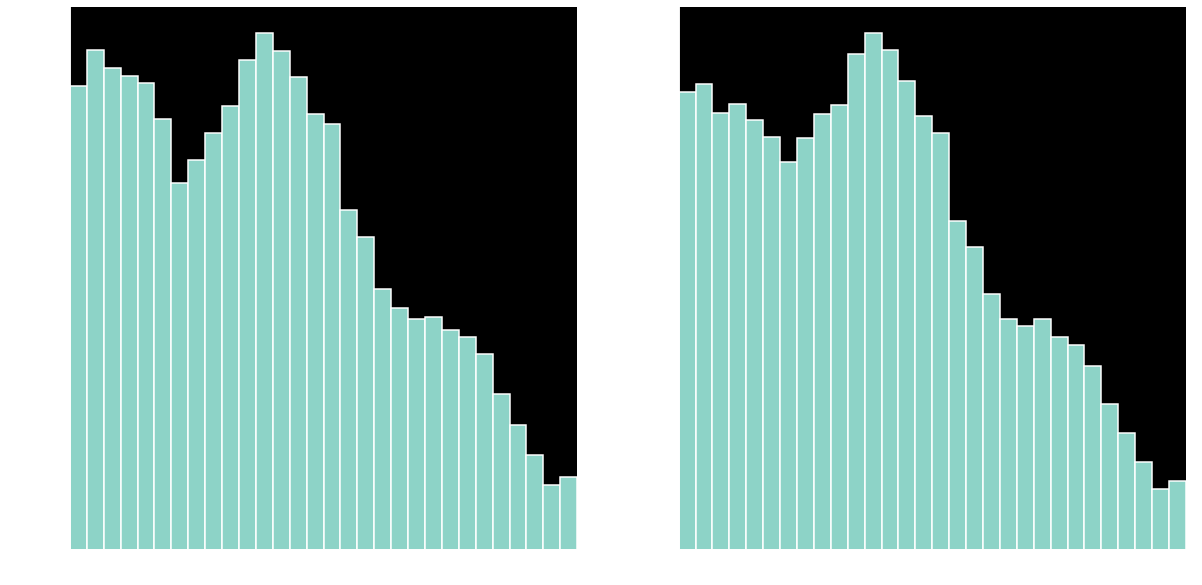

In [13]:
# plot NORMALIZED histograms
# (density=True)

fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].set_xlim([0, 90])
axes[0].hist(df['age'],bins=30,density=True)
axes[1].set_xlim([0, 90])
axes[1].hist(df['age'],bins=30,weights=df['instance weight'],density=True)
sns.despine()

Let's have a look at the label feature.

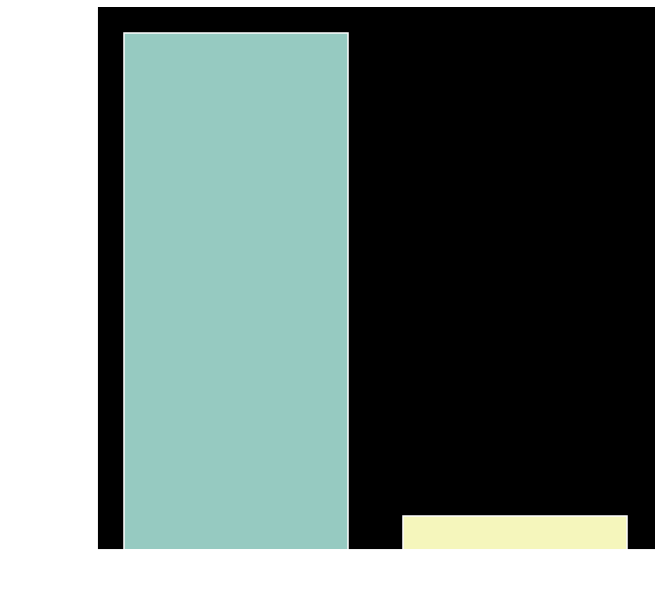

In [14]:
plt.figure(figsize=(10,10))
sns.countplot(df['label'])
sns.despine()

There is a big class imbalance, aggravated by the presence of samples of a young age.
Let's do one more sanity check with the weights.

In [15]:
# unweighted frequencies of labels
total_samples = len(df)
df.groupby('label').count()['age']/total_samples

label
- 50000.    0.937942
50000+.     0.062058
Name: age, dtype: float64

In [16]:
# weighted frequencies of labels
total_wts = df['instance weight'].sum()
df.groupby('label').sum()['instance weight']/total_wts

label
- 50000.    0.93595
50000+.     0.06405
Name: instance weight, dtype: float64

# Continuous features
Let's plot histograms for the continuous features. We do that by splitting data according to which class label they belong (<50k or >50k), to see if any feature separates nicely.

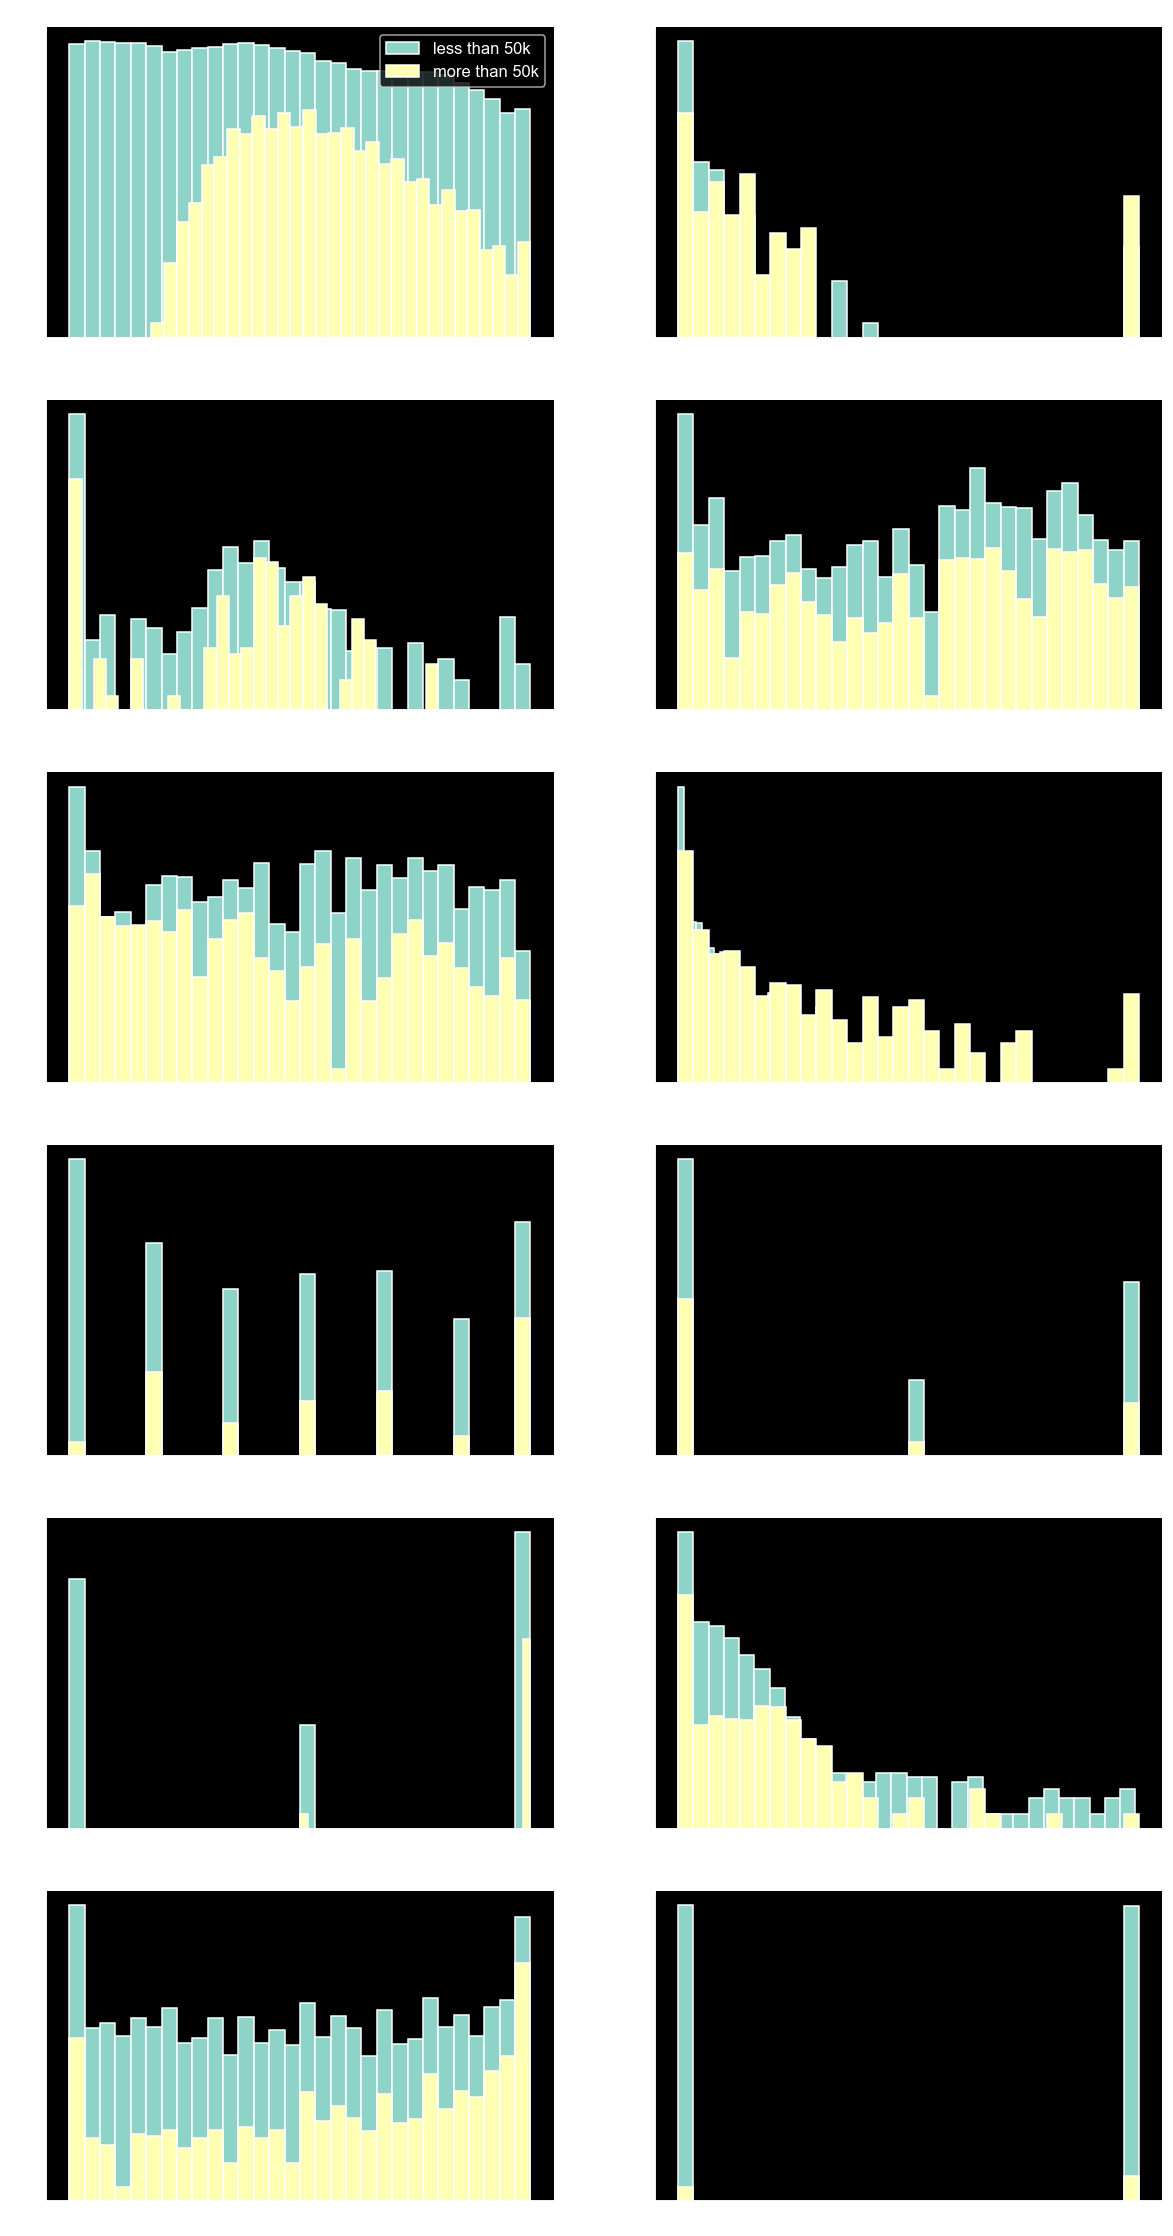

In [17]:
# use logarithmic scale
class_0 = df[df['label'] == "- 50000."]
class_1 = df[df['label'] == "50000+."]

numerical_features = sorted(list(var_cont))

fig, axes = plt.subplots(6,2,figsize=(20,40))
ax = axes.ravel()
for i in range(12):
    ax[i].hist(class_0[numerical_features[i]],bins=30,density=False)
    ax[i].hist(class_1[numerical_features[i]],bins=30,density=False)
    ax[i].set_title(numerical_features[i])
    ax[i].set_yscale('log')
    sns.despine()
ax[0].legend(['less than 50k', 'more than 50k'])

## Continuous features: remarks
* age, capital gains, and dividends have some ability to separate labels (unsurprisingly)
* 'own busines or self employed', 'veterans benefits', 'year' should be treated as categorical variables.

From https://archive.ics.uci.edu/ml/datasets/Census-Income+(KDD) and https://www2.census.gov/programs-surveys/cps/techdocs/cpsmar19.pdf we learn how to interpret these values. As expected, 0 stands for 'Not in Universe', 1 for 'yes', 2 for 'no'.

* 'num persons worked for employer' is a bit of a hybrid: it's categorical, 0 stands for Not in Universe, but the bigger the number the more people are employed by the company. We will keep it as continuous.

In [28]:
# convert vars from cont to disc
to_change = set(['own business or self employed',
                'num persons worked for employer',
                'veterans benefits',
                'year'])

for col_name in to_change:
    var_cont.remove(col_name)
    var_disc.add(col_name)

# Discrete variables
Let's plot some bars for the rest of the data.

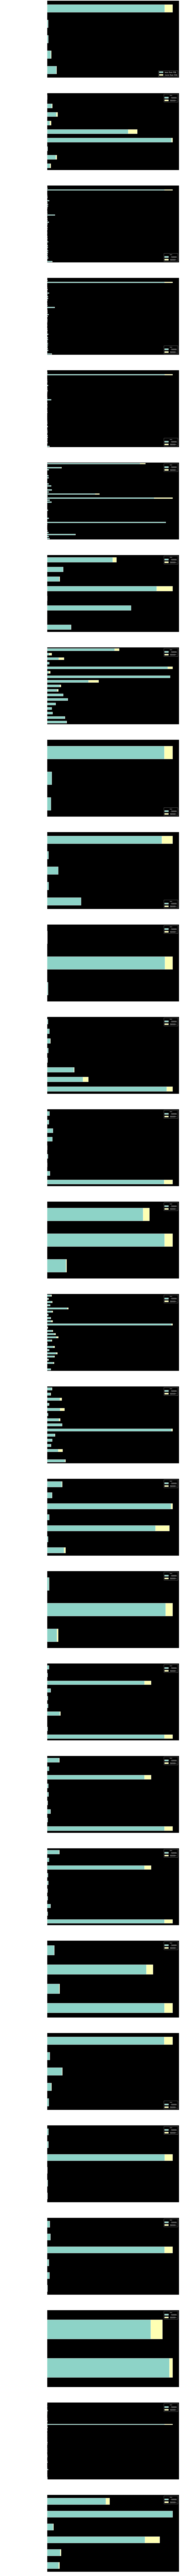

In [18]:
categorical_features = sorted(list(var_disc))

fig, axes = plt.subplots(28,1,figsize=(20,400))
ax = axes.ravel()
for i in range(28):
    col_name = categorical_features[i]
    df_plot = df.groupby(['label', col_name]).size().reset_index().pivot(columns='label', index=col_name, values=0)
    df_plot.plot(kind='barh', stacked=True, ax=ax[i])
    sns.despine()
    
ax[0].legend(['less than 50k', 'more than 50k'])

Many features have multiple categories, some with very few entries.
Before we do any feature selection, let's look at 
## Correlations
For convenience, let's reload the data.

In [185]:
def load_data_from_two(path_to_data,path_to_cols):
    """
    loads data and returns a pandas dataframe
    requires: import pandas as pd
    """
    col_names = []
    with open('census-income.columns', 'r') as f:
        for line in f.readlines():
            col_names.append(line[:-1])

    df = pd.read_csv('census-income.data', names=col_names)
    return df

def fill_nan_hisp(data):
    """
    assumes data is a pandas dataframe
    modifies data in place
    """
    assert 'hispanic origin' in data.columns, "Hispanic column missing"
    data['hispanic origin'].fillna(value='All other', inplace=True)
    return None

def encode_cols(data):
    """
    ad hoc function to create 0/1 column for label
    """
    from sklearn.preprocessing import LabelEncoder
    data['label_encoded'] = LabelEncoder().fit_transform(data['label'])
    data['sex_encoded'] = LabelEncoder().fit_transform(data['sex'])
    data['year_encoded'] = LabelEncoder().fit_transform(data['year'])
    return None

def bucket_features(data):
    """
    assumes data is a pandas dataframe containing data types object, float, and int.
    returns two sets of column names, according to type float or other
    """
    numerical_types = ['int64', 'float64']
    var_cont = set()
    var_disc = set()
    for col in data.columns:
        if data.dtypes[col] in numerical_types:
            var_cont.add(col)
        else:
            var_disc.add(col)

    to_swap=['veterans benefits',
            'own business or self employed']

    for col_name in to_swap:
        var_cont.remove(col_name)
        var_disc.add(col_name)

    return (var_cont,var_disc)

def load_for_training(path_to_data,path_to_columns,make_dummies=False):
    # load data from files
    df = load_data_from_two('census-income.data', 'census-income.columns')

    # fill nans from hispanic column
    fill_nan_hisp(df)
    # encode sex and label columns
    encode_cols(df)

    # split outputs and weights from data
    y = df['label_encoded']
    w = df['instance weight']
    
    # drop label,instance weight, and sex
    df = df.drop(columns=['label','instance weight', 'label_encoded', 'sex', 'year'])

    # drop correlated features
    to_drop = ['migration code-change in msa',
                'detailed industry recode',
                'detailed occupation recode',
                'migration code-move within reg',
                'live in this house 1 year ago',
                "fill inc questionnaire for veteran's admin",
                'migration code-change in reg',
                'migration prev res in sunbelt',
                'major industry code',
                'state of previous residence',
                'detailed household and family stat']

    df = df.drop(columns=to_drop)

    # group features by type
    var_cont,var_disc = bucket_features(df)

    if make_dummies:
        df = pd.get_dummies(df, columns=var_disc)

    return df

def get_sorted_feats_by_corr(data):
    """
    data is pandas dataframe
    returns corr_vals sorted by abs value
    """
    cols = data.columns
    dupes_to_drop = { (data.columns[i],data.columns[j]) for i in range(data.shape[1]) for j in range(i+1) }
    
    return data.corr().abs().unstack().drop(labels=dupes_to_drop).sort_values(ascending=False)

In [186]:
df = load_for_training('census-income.data','census-income.columns',make_dummies=False)
df_dummies = load_for_training('census-income.data','census-income.columns',make_dummies=True)

In [187]:
F = get_sorted_feats_by_corr(df_dummies)

In [188]:
# we reloaded these correlation values a few times, until we got rid of a bunch of duplicate features
F

class of worker_Never worked                                        reason for unemployment_New entrant                                     1.000000e+00
country of birth self_United-States                                 citizenship_Native- Born in the United States                           9.999250e-01
education_Children                                                  veterans benefits_0                                                     9.998202e-01
major occupation code_Not in universe                               class of worker_Not in universe                                         9.956089e-01
veterans benefits_0                                                 veterans benefits_2                                                     9.733003e-01
education_Children                                                  veterans benefits_2                                                     9.731206e-01
country of birth self_Puerto-Rico                                   citizenship_Na

detailed household summary in household_Nonrelative of householder            detailed household and family stat_Secondary individual 